# Perros vs. Gatos 🐩🤜🏼🤛🏼🐈‍⬛
Este es un ejemplo clásico de aplicación de CNN (Convolutional Neural Networks) para diferenciar imágenes de perros y gatos. Está adaptado para mostrar lo necesario sobre este tema, pero pueden encontrar una aplicación más completa (en métricas, decisiones, etc) en [Kaggle](https://www.kaggle.com/code/uysimty/keras-cnn-dog-or-cat-classification), además de esta implementación, hay [otra](https://www.kaggle.com/code/sachinpatil1280/cats-vs-dogs-image-classification-using-cnn-95) que usa TensorFlow en vez de Keras, entre varias más.

El *dataset* contiene 25.000 imágenes de perros y gatos con la siguiente **etiqueta**
* 1 = perro 🐩
* 0 = gato 🐈‍⬛

In [74]:
# importamos librerias

import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


In [75]:
# Esto no es relevante en temas de CNN, pero tengo las imágenes en una carpeta de mi Drive
# Si quisieran hacer una copia, pueden conseguir el dataset en el link de Kaggle más arriba

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
base_path = '/content/drive/MyDrive/AY13/'

filenames = os.listdir(base_path+"train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    # print(category)
    if category == "dog":
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

1974


In [105]:
df.head()

,filename,category
0,dog.3144.jpg,1
1,cat.8553.jpg,0
2,dog.5535.jpg,1
3,cat.4369.jpg,0
4,cat.1211.jpg,0


In [106]:
df.tail()

,filename,category
1969,cat.10556.jpg,0
1970,cat.4008.jpg,0
1971,dog.8416.jpg,1
1972,dog.372.jpg,1
1973,cat.12341.jpg,0


In [116]:
# definimos constantes

FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

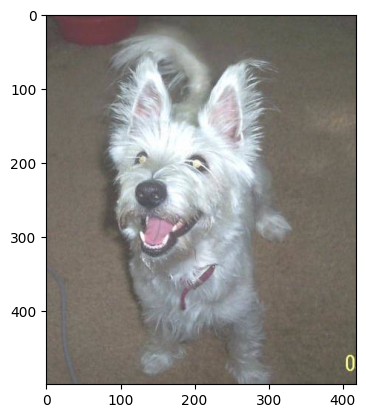

In [108]:
# Aqui una foto random para que vean como son :)


image = load_img(base_path+"train/dog.206.jpg")
plt.imshow(image)

## ¿Cómo se ve el modelo? 🔬


* Input Layer: Representa la información de input de las imágenes, que son cada pixel, "achatado" para hacer un vector de una dimensión. Por ejemplo, una imagen con 50 pixeles de ancho y 50 pixeles de alto termina siendo un vector de 50x50 = 2500 entradas, de dimensiones (2500,1)

* Capa convolucional: Esta capa va a extraer las *features* de la imagen.

* Capa de pooling: Esta capa reduce el volumen espacial de la imagen de input luego de la convolucion, es una especie de muestreo

* Capa Fully-Connected: IConecta la red desde la capa de poling a otra capa de neuronas "normales"

* Output Layer: Son los valores predecidos.

Se harán 3 mega-capas que contendrán un capa convolucional, una normalización del batch, una capa de pooling y una capa de dropout (que "mata" a las neuronas que no fueron activadas para optimizar el procesamiento)

In [109]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# Mega capa 1

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))  # capa convolucional
model.add(BatchNormalization())                                                                            # normalizacion de batch
model.add(MaxPooling2D(pool_size=(2, 2)))                                                                  # capa de pooling
model.add(Dropout(0.25))                                                                                   # capa de dropout


# Mega capa 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))  # tiene una capa de
model.add(Dropout(0.25))


# Mega capa 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Capa fully conected y output layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)       

## Predicción

In [110]:
# reduccion de learning rate

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]



In [111]:
# preparamos la data

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)


In [112]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [113]:
# no es necesario que revisen esto, es una forma de generar el entrenamiento
train_path = base_path + "train/"
print(train_path)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

/content/drive/MyDrive/AY13/train/
Found 1579 validated image filenames belonging to 2 classes.


In [114]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    train_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 395 validated image filenames belonging to 2 classes.


In [117]:
# momento de entrenar el modelo

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-117-416043ffbcd8>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
105/105 [==============================] - ETA: 0s - loss: 1.2476 - accuracy: 0.5556

105/105 [==============================] - 115s 1s/step - loss: 1.2476 - accuracy: 0.5556 - val_loss: 0.7027 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 2/3
105/105 [==============================] - ETA: 0s - loss: 1.0265 - accuracy: 0.5646

105/105 [==============================] - 114s 1s/step - loss: 1.0265 - accuracy: 0.5646 - val_loss: 1.2772 - val_accuracy: 0.4641 - lr: 0.0010
Epoch 3/3
105/105 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.5697

105/105 [==============================] - 112s 1s/step - loss: 0.8622 - accuracy: 0.5697 - val_loss: 1.4958 - val_accuracy: 0.4795 - lr: 0.0010


In [120]:
# preparando datos de testeo

test_filenames = os.listdir(base_path + "test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [124]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    base_path + "test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 434 validated image filenames.


In [125]:
# predicción

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<ipython-input-125-3fb42224ea53>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


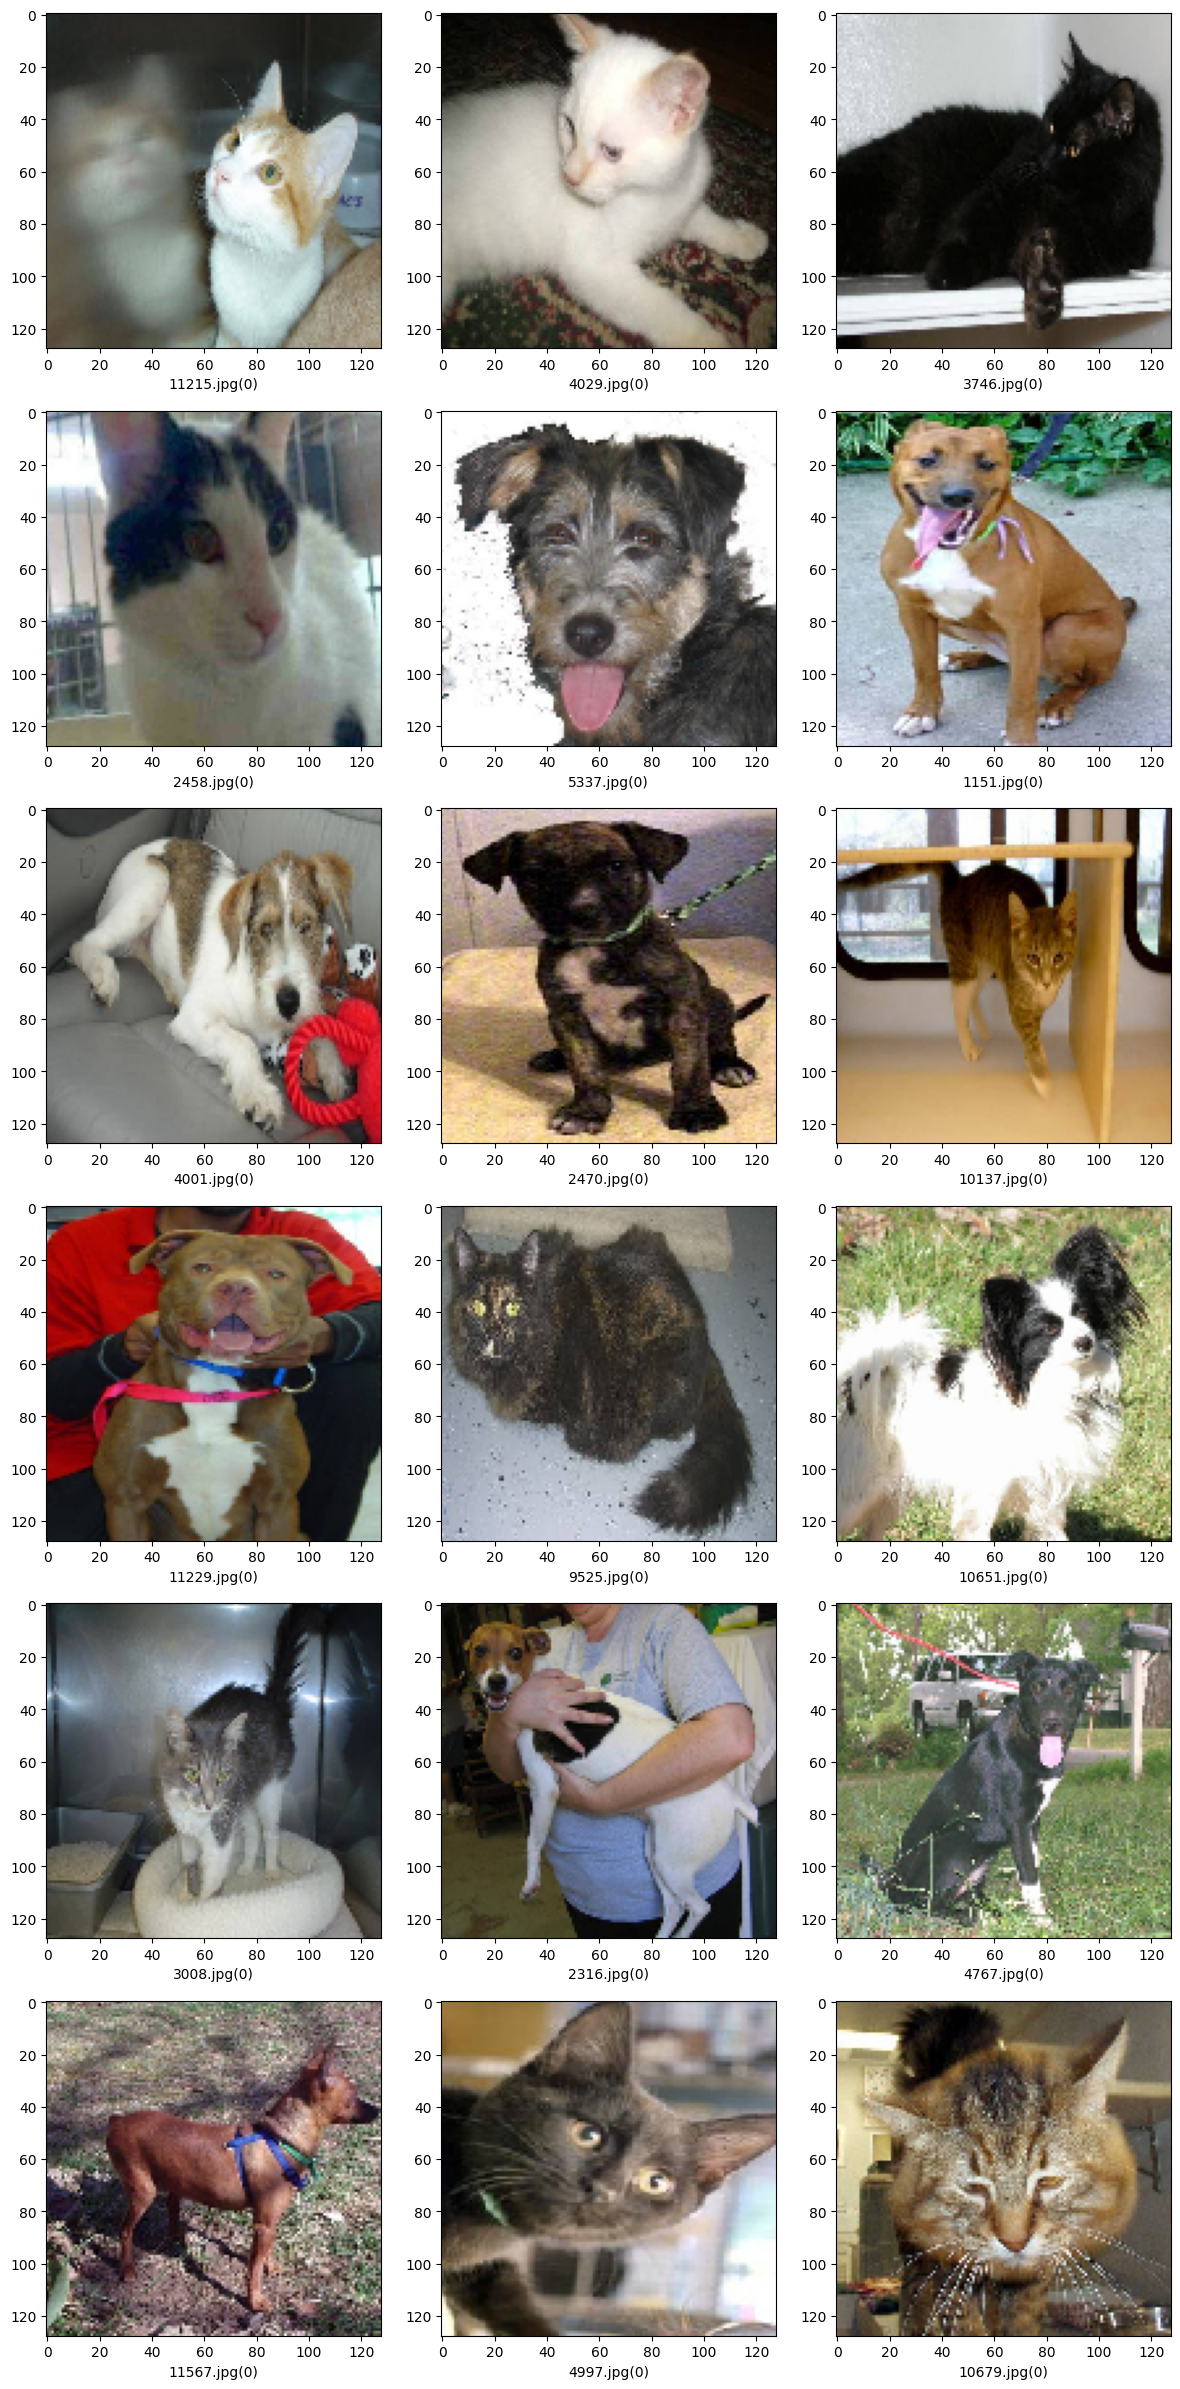

In [127]:
# prediccion con imagenes

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(base_path+"test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()